In [1]:
## Choose GPU to be used in the environment
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
## Import library
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.special import softmax

In [3]:
## Load experiment dataset
train = pd.read_csv(r'christoferoctovianto/id-sa-in-ne/masked_dataset/dataset_experiment/masked_env_id_train.xlsx')
train_data = train[['text_clean','label']].copy()
train_data.columns = ['text', 'labels']
validation = pd.read_csv(r'christoferoctovianto/id-sa-in-ne/masked_dataset/dataset_experiment/masked_env_id_valid.xlsx')
validation_data = validation[['text_clean','label']].copy()
validation_data.columns = ['text', 'labels']
test = pd.read_csv(r'christoferoctovianto/id-sa-in-ne/masked_dataset/dataset_experiment/masked_env_id_test.xlsx')
test_data = test[['text_clean','label']].copy()
test_data.columns = ['text', 'labels']

In [4]:
## Display experiment dataset
print('train data:')
display(train_data)
print('\nvalidation data:')
display(validation_data)
print('\ntesting data:')
display(test_data)

train data:


,text,labels
0,masyarakat di jakabaring pagi ini jumat 16 4 2...,POSITIVE
1,mini class pengenalan proyek blue carbon meman...,NEUTRAL
2,bapak batam apresiasi beroperasinya perusahaan...,POSITIVE
3,detikers merasa tidak sih kalau kualitas udara...,NEGATIVE
4,hai sobat envira bank dunia menganggap indones...,POSITIVE
...,...,...
1524,kisah dari reaktor chernobyl letupan reaktor n...,NEGATIVE
1525,ayo belajar mendaur ulang sampah demi masa dep...,POSITIVE
1526,polusi udara umumnya terjadi karena faktor ala...,POSITIVE
1527,polusi udara telah menjadi masalah yang semaki...,NEGATIVE



validation data:


,text,labels
0,halo orang muda apa saja sih dampak dari krisi...,NEUTRAL
1,bumi telah menanggung beban sampah yang sangat...,NEGATIVE
2,kualitas udara yang tidak sehat di jakarta dan...,NEGATIVE
3,tidak terasa makin menambah banyak mencoba men...,POSITIVE
4,pencemaran udara adalah kehadiran satu atau le...,NEGATIVE
...,...,...
378,fakta menarik sampah masker masyarakat masker ...,POSITIVE
379,repost from penandaan logo ekolabel pada produ...,POSITIVE
380,jika ekosistem laut terancam perubahan iklim e...,NEGATIVE
381,masalah sampah tentu menjadi masalah bersama y...,POSITIVE



testing data:


,text,labels
0,selamat hari bumi internasional mari kita berk...,POSITIVE
1,kapan lagi nih dengan hanya memilah sampah bis...,POSITIVE
2,warga jakarta bagaimana testimoninya coba kome...,NEUTRAL
3,hari lingkungan hidup sedunia ini sebagai mome...,POSITIVE
4,el nino adalah pola iklim alami yang terkait d...,NEUTRAL
...,...,...
474,repost ketua bhayangkari cabang konawe daerah ...,POSITIVE
475,banjir macet dan polusi udara menjadi pekerjaa...,POSITIVE
476,seberapa aman dan murahkah pltn itu tentu saja...,NEGATIVE
477,sudah banyak aturannya tapi buang sampah semba...,NEGATIVE


In [5]:
## Encode label in each dataset
label_encoder = LabelEncoder()
train_data["labels"] = label_encoder.fit_transform(train_data["labels"])
validation_data["labels"] = label_encoder.transform(validation_data["labels"])
test_data["labels"] = label_encoder.fit_transform(test_data["labels"])

In [6]:
## Check label encoder
label_encoder.inverse_transform(np.array([0,1,2]))

array(['NEGATIVE', 'NEUTRAL', 'POSITIVE'], dtype=object)

In [7]:
## Check label encoder
label_encoder.classes_

array(['NEGATIVE', 'NEUTRAL', 'POSITIVE'], dtype=object)

median:  81.0
mean:  96.81164159581425

histogram:


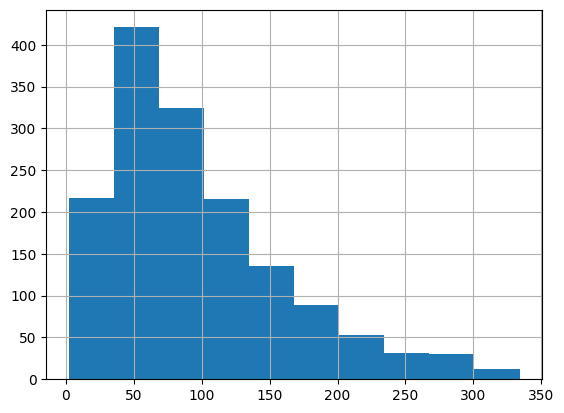

In [8]:
## Calculate average length and median of sentences in train_data
df = train_data.copy()
def calculate_length(param):
    return len(param.split())
df['length'] = df['text'].apply(calculate_length)
print('median: ', df['length'].median())
print('mean: ', df['length'].mean())

## Histogram of sentence length in train_data
print('\nhistogram:')
df['length'].hist()
plt.show()

In [10]:
## Optional model configuration
model_args = ClassificationArgs(num_train_epochs=3, train_batch_size=16, eval_batch_size=16, evaluate_during_training=True,
                                learning_rate=1e-5, max_seq_length=128, output_dir='outputs_indobert_litelarge/', 
                                best_model_dir='outputs_indobert_litelarge/best_model',
                                overwrite_output_dir= False, use_multiprocessing=False, 
                                use_multiprocessing_for_evaluation=False, no_cache=True)

## Create a ClassificationModel
model = ClassificationModel(
    'bert',
    'indobenchmark/indobert-lite-large-p2',
    num_labels=3,
    args=model_args,
    ignore_mismatched_sizes=True
)

You are using a model of type albert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-lite-large-p2 and are newly initialized: ['classifier.bias', 'classifier.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'enc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-lite-large-p2 and are newly initialized because the shapes did not match:
- embeddings.word_embeddings.weight: found shape torch.Size([30000, 128]) in the checkpoint and torch.Size([30000, 1024]) in the model instantiated
- embeddings.position_embeddings.weight: found shape torch.Size([512, 128]) in the checkpoint and torch.Size([512, 1024]) in the model instantiated
- embeddings.token_type_embeddings.weight: found shape torch.Size([2, 128]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
- embeddings.LayerNorm.weight: found shape torch.Size([128]) in the checkpoint and torch.Size([1024]) in the model instantiated
- embeddings.LayerNorm.bias: found shape torch.Size([128]) in the checkpoint and torch.Size([1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
## Train classification model
train_result = model.train_model(train_data, eval_df=validation_data)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/96 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/96 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/96 [00:00<?, ?it/s]

In [21]:
## Use the best model from training results
model = ClassificationModel(
    "bert", 'outputs_indobert_litelarge/best_model'
)

In [22]:
## Evaluate the model on test_data
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='macro')
def precision_multiclass(labels, preds):
    return precision_score(labels, preds, average='macro')
def recall_multiclass(labels, preds):
    return recall_score(labels, preds, average='macro')
result, model_outputs, wrong_predictions = model.eval_model(test_data, f1=f1_multiclass, 
                                                            acc=accuracy_score, precision=precision_multiclass, 
                                                            recall=recall_multiclass)

Running Evaluation:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
## Check result
print(result)

{'mcc': 0.3974243373445948, 'f1': 0.4666370973703487, 'acc': 0.6617954070981211, 'precision': 0.43737373737373736, 'recall': 0.5021286549707602, 'eval_loss': 0.8264302213986715}


Accuracy model on data test:  0.6617954070981211
Precision model on data test:  0.43737373737373736
Recall model on data test:  0.5021286549707602
F1 Score model on data test:  0.4666370973703487 

Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.60      0.75      0.67       171
     NEUTRAL       0.00      0.00      0.00        58
    POSITIVE       0.71      0.75      0.73       250

    accuracy                           0.66       479
   macro avg       0.44      0.50      0.47       479
weighted avg       0.59      0.66      0.62       479
 



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

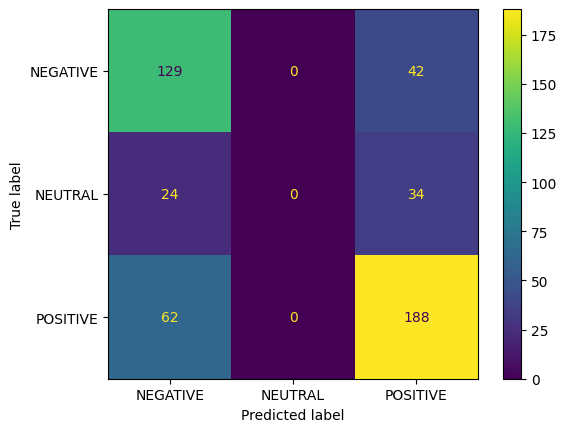

In [24]:
## Create confusion matrix with sklearn
# Prepare true and prediction labels
y_pred_prob = softmax(model_outputs, axis=1)
y_pred = np.argmax(y_pred_prob,axis=1)
y_true = np.array(test_data['labels'])
# Print classification output
print('Accuracy model on data test: ',accuracy_score(y_true, y_pred))
print('Precision model on data test: ',precision_score(y_true, y_pred, average="macro"))
print('Recall model on data test: ',recall_score(y_true, y_pred, average="macro"))
print('F1 Score model on data test: ',f1_score(y_true, y_pred, average="macro"), '\n')
# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=label_encoder.classes_), '\n')
# Plot confusion matrix
cm = confusion_matrix(label_encoder.inverse_transform(y_true), label_encoder.inverse_transform(y_pred), 
                      labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()
plt.show()

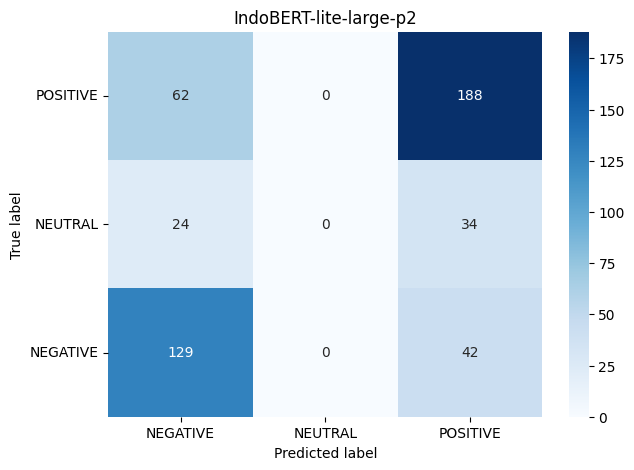

In [25]:
## Create confusion matrix with seaborn
cm2 = cm.copy()
cm2[2,:] = cm[0,:]
cm2[0,:] = cm[2,:]
f, ax = plt.subplots(figsize=(7, 5))
label = np.array(['POSITIVE','NEUTRAL','NEGATIVE'])
sns.heatmap(cm2, cmap='Blues', annot=True, fmt="d", xticklabels=label[::-1], yticklabels=label)
ax.set_title('IndoBERT-lite-large-p2')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_label_position('bottom')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show()

In [26]:
## Test the model on train_data
result_train, model_outputs_train, wrong_predictions_train = model.eval_model(train_data, f1=f1_multiclass, 
                                                            acc=accuracy_score, precision=precision_multiclass, 
                                                            recall=recall_multiclass)
print(result_train)

Running Evaluation:   0%|          | 0/96 [00:00<?, ?it/s]

{'mcc': 0.5584780260485743, 'f1': 0.5281046913141455, 'acc': 0.7482014388489209, 'precision': 0.4950496701122251, 'recall': 0.5688799694189602, 'eval_loss': 0.664040993899107}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
## Test the model on validation_data
result_valid, model_outputs_valid, wrong_predictions_valid = model.eval_model(validation_data, f1=f1_multiclass, 
                                                            acc=accuracy_score, precision=precision_multiclass, 
                                                            recall=recall_multiclass)
print(result_valid)

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

{'mcc': 0.49140366883585473, 'f1': 0.5025393089262805, 'acc': 0.7154046997389034, 'precision': 0.4715006610431447, 'recall': 0.5384108867427568, 'eval_loss': 0.7039943809310595}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
## save predictions on test_data in csv file
test['labels_prediction'] = label_encoder.inverse_transform(y_pred)
display(test)
test.to_excel(r'christoferoctovianto/id-sa-in-ne/result/masked_prediction_indobert_litelarge.xlsx', index=False)

,id_shortcode,topic,text,text_clean,label,labels_prediction
0,CrWCa-5vwsE,Climate change,🌿 Selamat Hari Bumi Internasional!\n\nMari kit...,selamat hari bumi internasional mari kita berk...,POSITIVE,POSITIVE
1,Cs5PpWISlMC,Waste,Kapan lagi nih dengan hanya memilah sampah bis...,kapan lagi nih dengan hanya memilah sampah bis...,POSITIVE,POSITIVE
2,Cfyk5nsvHea,Energy,Warga Jakarta gimana testimoninya? Coba komen ...,warga jakarta bagaimana testimoninya coba kome...,NEUTRAL,NEGATIVE
3,CtGphpxywpJ,Waste,Hari Lingkungan Hidup Sedunia ini sebagai mome...,hari lingkungan hidup sedunia ini sebagai mome...,POSITIVE,POSITIVE
4,Ct1QRF7p9MA,Climate change,El Nino adalah pola iklim alami yang terkait d...,el nino adalah pola iklim alami yang terkait d...,NEUTRAL,NEGATIVE
...,...,...,...,...,...,...
474,Ctf42dySp1Y,Environment,#Repost @bhayangkari_pc_konawe_sultra \n\nKetu...,repost ketua bhayangkari cabang konawe daerah ...,POSITIVE,POSITIVE
475,Cqd9BO4ySiB,Pollution,"Banjir, Macet dan polusi udara menjadi PR warg...",banjir macet dan polusi udara menjadi pekerjaa...,POSITIVE,NEGATIVE
476,CsC_M1WvPc6,Energy,Seberapa aman dan murahkah PLTN itu? Tentu saj...,seberapa aman dan murahkah pltn itu tentu saja...,NEGATIVE,NEGATIVE
477,Ct-jH09vLMc,Environment,"Sudah banyak aturannya, tapi buang sampah semb...",sudah banyak aturannya tapi buang sampah semba...,NEGATIVE,POSITIVE
